In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

lm_path = f"../../language_modeling.csv"
mcp_path = f"../../multiple_choice_prompt.csv"
cha_path = f"../../channel.csv"
cal_path = f"../../calibration.csv"
# cd_path = f"../old_results/cd_two_methods.csv" # old comprehensive results.
cd_path = f"./contrastive_decoding.csv"
lm_df = pd.read_csv(lm_path)
mcp_df = pd.read_csv(mcp_path)
cha_df = pd.read_csv(cha_path)
cal_df = pd.read_csv(cal_path)
cd_df = pd.read_csv(cd_path)

In [38]:
# drop columns should be a list. Use type hints to enforce this.
def process(df, drop_columns=None):
    # get rid of identical rows 
    df = df.drop_duplicates() # is this really necessary?
    # df = df[df["checkpoint"].str.startswith("google/flan-t5")]
    # remove the seed column and batch_size column
    if isinstance(drop_columns, list):
        drop_columns += ["model_family", "seed", "batch_size", "loading_precision", "sample"]
    else:
        drop_columns = ["model_family", "seed", "batch_size", "loading_precision", "sample"]
    df = df.drop(columns=drop_columns)
    # shorten checkpoint names
    df['checkpoint'] = df["checkpoint"].apply(lambda x: x.split("/")[-1])
    return df
    

In [39]:
lm_df = process(lm_df)
mcp_df = process(mcp_df)
cha_df = process(cha_df)
cal_df = process(cal_df)
cd_df = process(cd_df, drop_columns=["expert_method", "amateur_method", "amateur_checkpoint", "weighting_parameter", "expert_accuracy", "amateur_accuracy"]) # 

pre_df = pd.concat([lm_df, mcp_df, cha_df, cal_df, cd_df]) 

In [6]:
cd_df.head()

,checkpoint,dataset,method,n_shot,accuracy
0,pythia-2.8b,anli,contrastive_decoding,0,0.4500
1,pythia-2.8b,code_line_description,contrastive_decoding,0,0.6897
2,pythia-2.8b,conceptual_combinations,contrastive_decoding,0,0.3300
3,pythia-2.8b,copa,contrastive_decoding,0,0.7200
4,pythia-2.8b,cqa,contrastive_decoding,0,0.4400


In [40]:
n_shot = 0 # 4.0, 0
model = 'pythia-2.8b'
datasets="anli copa cqa obqa piqa winogrande code_line_description conceptual_combinations disambiguation_qa emoji_movie ruin_names temporal_sequences".split()
df = pre_df[pre_df["n_shot"] == n_shot]
df = df[(df["dataset"].isin(datasets)) & (df["checkpoint"] == model)]

In [17]:
df.head()

,checkpoint,dataset,method,n_shot,accuracy
230,pythia-2.8b,anli,language_modeling,0,0.34
231,pythia-2.8b,anli,average_language_modeling,0,0.35
232,pythia-2.8b,copa,language_modeling,0,0.83
233,pythia-2.8b,copa,average_language_modeling,0,0.80
234,pythia-2.8b,cqa,language_modeling,0,0.47


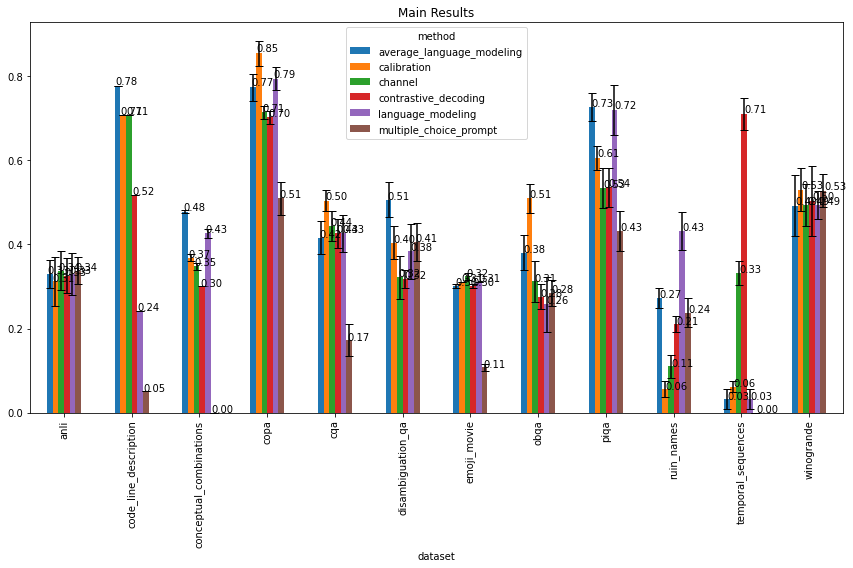

In [43]:
# plot
fig, ax = plt.subplots(figsize=(12, 8))
# group by dataset and method
grouped = df.groupby(["dataset", "method"])
# get the mean and std of the accuracy
mean = grouped["accuracy"].mean().unstack()
std = grouped["accuracy"].std().unstack()
# plot the mean and std
mean.plot.bar(yerr=std, 
              ax=ax, 
              capsize=4, 
              title=f"Main Results",
              )
# add numbers to each bar, with at most 2 decimal places
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", (p.get_x() * 1.005, p.get_height() * 1.005))
plt.tight_layout()
fig.savefig(f"cd_main.png", bbox_inches='tight', dpi=300)


In [42]:
latex_df = mean.applymap(lambda x: f"{x*100:.1f}") + std.applymap(lambda x: f"\\textsubscript{{{x*100:.1f}}}")
method_index = ['average_language_modeling', 'calibration', 'channel', 'language_modeling', 'multiple_choice_prompt', 'contrastive_decoding']
latex_df = latex_df.reindex(method_index, axis="columns")
latex_df = latex_df.rename(columns={"average_language_modeling": "avg",
                                    "language_modeling": "lm",
                                    "multiple_choice_prompt": "mcp",
                                    "contrastive_decoding": "cd",
                                    "channel": "cha",
                                    "calibration": "cal",
                                    },
                                    index={"code_line_description": "cld",
                                           "conceptual_combinations": "cc",
                                           "disambiguation_qa": "dq",
                                           "emoji_movie": "em",
                                           "ruin_names": "rn",
                                           "temporal_sequences": "ts",
                                           })

latex_df.style.to_latex(
    buf=f"cd_main.tex",
    column_format="l" + "c" * len(latex_df.columns),
    position="h",
    position_float="centering",
    label="tab:cd_main",
    caption="Main results of contrastive decoding.",
    multicol_align="c",
    multirow_align="c",
)